In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Looking at CC Cet's TESS lightcurve. It's...odd. Porb = 6.82 hours.

In [3]:
hdul = fits.open('MAST_2019-11-14T1546/TESS/tess2018292075959-s0004-0000000407588360-0124-s/tess2018292075959-s0004-0000000407588360-0124-s_lc.fits')

In [4]:
data = hdul[1].data

/home/david/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:108: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)


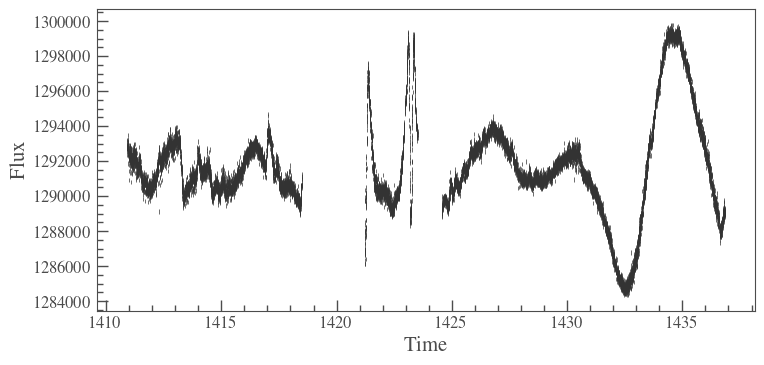

In [5]:
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
t, f, e = t[q==0], f[q==0], e[q==0]
lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
lc=lc.remove_nans()
lc.errorbar()

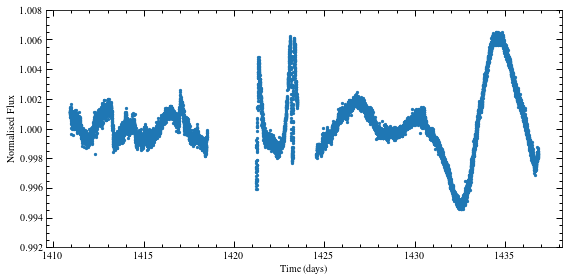

In [6]:
plt.figure(figsize=(8,4))
plt.scatter(lc.time, lc.flux/np.median(lc.flux),s=5, rasterized=True)
plt.ylabel('Normalised Flux')
plt.xlabel('Time (days)')
#plt.xlabel('BJD - 2457000 (days)')
plt.ylim(0.992, 1.008)
plt.tight_layout()
plt.savefig('tess_test.png', dpi=150)

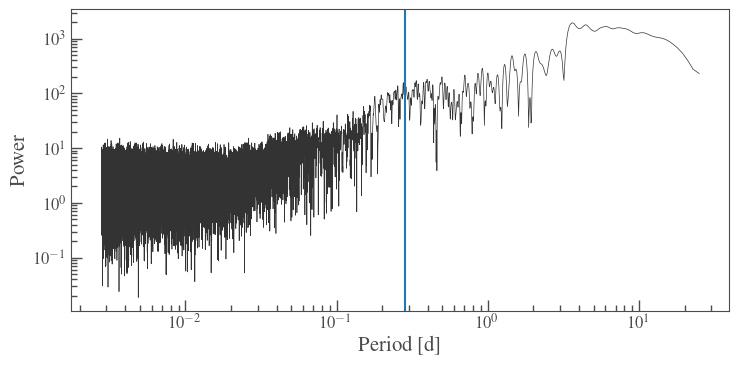

In [7]:
porb = 6.82*u.hour
pg = pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=25*u.day)
pg.plot(scale='log')
plt.axvline(porb.to(u.day).value)

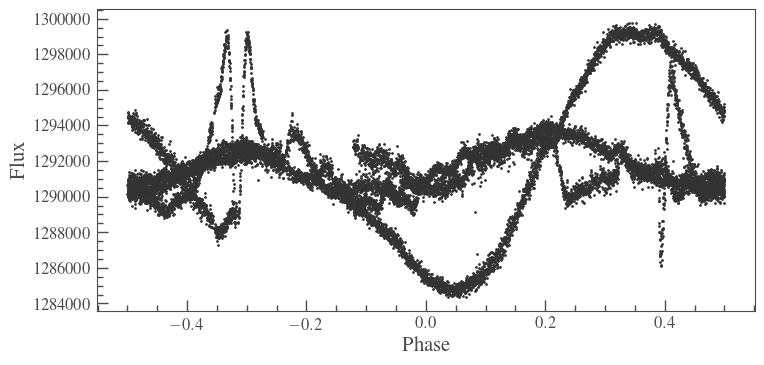

In [8]:
lc.fold(porb).scatter()

In [9]:
"""t_start = lc.time[0]
t_max = 0
while t_max < lc.time[-1]:
    t_max = t_start+porb.to(u.day).value
    mask = (lc.time > t_start) & (lc.time < t_max)
    plt.scatter(lc.time[mask], lc.flux[mask])
    plt.show()
    t_start = t_max"""

't_start = lc.time[0]\nt_max = 0\nwhile t_max < lc.time[-1]:\n    t_max = t_start+porb.to(u.day).value\n    mask = (lc.time > t_start) & (lc.time < t_max)\n    plt.scatter(lc.time[mask], lc.flux[mask])\n    plt.show()\n    t_start = t_max'

Looking at the TPF

In [27]:
tpf = lk.search_targetpixelfile('03:10:49.138+10:00:20.73', mission='TESS', sector=4).download(quality_bitmask='hardest')

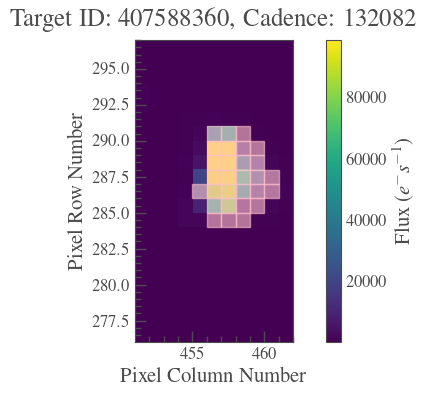

In [43]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

In [28]:
tpf.interact()

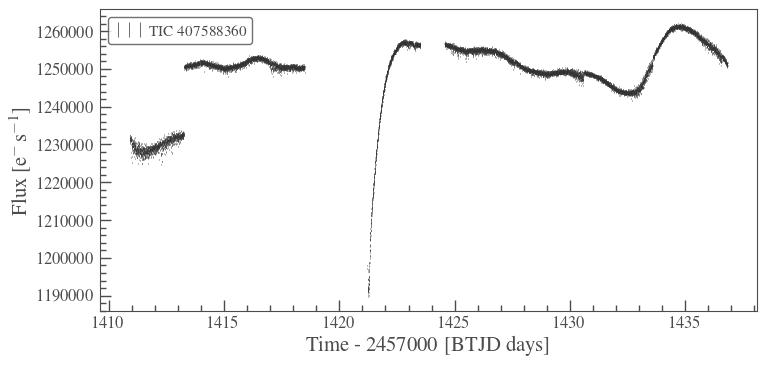

In [45]:
lc = tpf.to_lightcurve()
lc.errorbar()

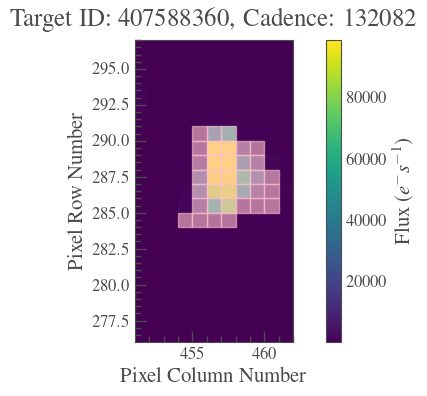

In [40]:
aperture_mask = tpf.create_threshold_mask(threshold=10)

# Plot that aperture
tpf.plot(aperture_mask=aperture_mask);



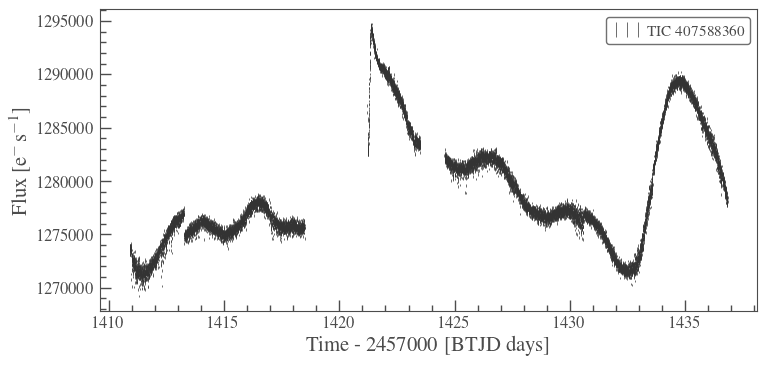

In [47]:
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.errorbar()

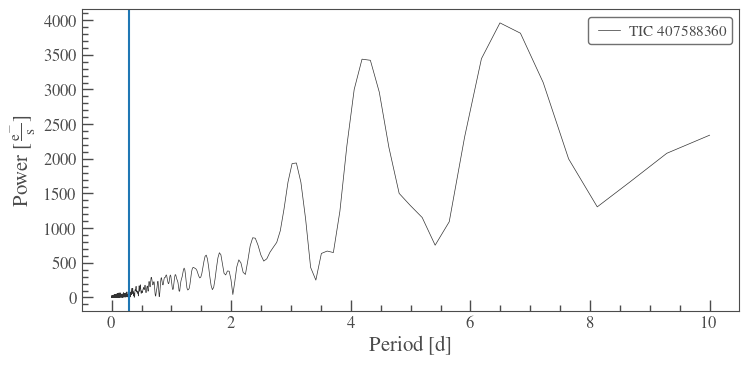

In [48]:
pg = lc.to_periodogram(maximum_period = 10*u.day, minimum_period=4*u.min)
pg.plot()
plt.axvline(porb.to(u.day).value)

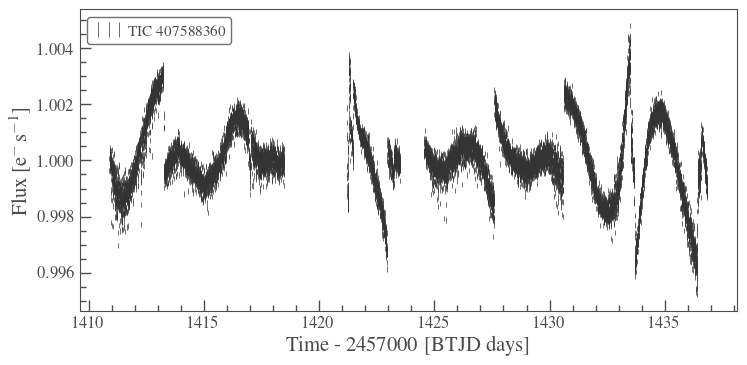

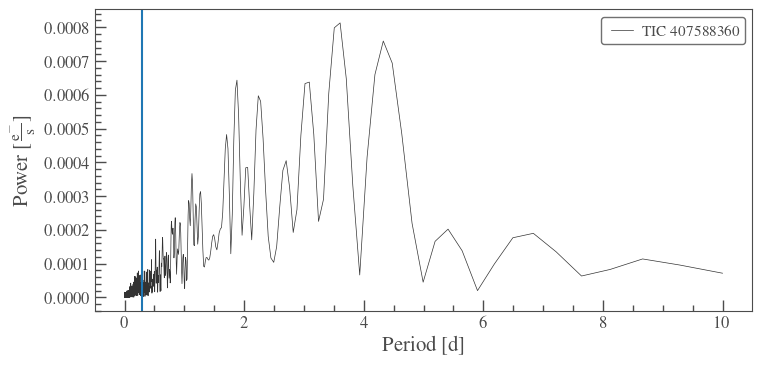

In [53]:
flat_lc = lc.flatten(window_length=12001)
flat_lc.errorbar();
pg2 = flat_lc.to_periodogram(maximum_period = 10*u.day, minimum_period=4*u.min)
pg2.plot()
plt.axvline(porb.to(u.day).value)

In [54]:
tpf.interact_sky()

In [57]:
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=47.81595104*u.degree, dec=10.04542054*u.degree, frame='icrs')
print(c.ra.hms, c.dec.dms)

hms_tuple(h=3.0, m=11.0, s=15.828249600002096) dms_tuple(d=10.0, m=2.0, s=43.51394400000103)


Wrong star? Where is CC Cet then?

In [58]:
tpf = lk.search_targetpixelfile('03:10:54.99+09:49:25.67', mission='TESS', sector=4)#.download(quality_bitmask='hardest')
tpf

SearchResult containing 0 data products.

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://localhost:8889';                       use --allow-websocket-origin=localhost:8889 or set BOKEH_ALLOW_WS_ORIGIN=localhost:8889 to permit this; currently we allow origins {'localhost:8888'}
ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://localhost:8889';                       use --allow-websocket-origin=localhost:8889 or set BOKEH_ALLOW_WS_ORIGIN=localhost:8889 to permit this; currently we allow origins {'localhost:8888'}


Solved! Was not observed at 2min cadance, Mast seach picks up a nearby star. Might be able to get something out of the FFIs?